# Notebook to develop the question asking capabilities of Hindsight
* Example question: How much battery does Hindsight use?

In [1]:
import os
import cv2
import sys
import glob
import pandas as pd

from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from statistics import mean

sys.path.insert(0, "../")
from db import HindsightDB
import utils
import prompts
from chromadb_tools import query_chroma, chroma_search_results_to_df

from mlx_lm import load, generate

/Users/connorparish/miniconda3/envs/hindsight_exp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
db = HindsightDB()

In [35]:
# db.update_chromadb_processed(frame_ids=set(frames['id']), value=False)

Updated chromadb_processed for 177293 frames.


In [2]:
chroma_search_results = query_chroma(query_text="dan is the best")
chroma_search_results_df = chroma_search_results_to_df(chroma_search_results)

/Users/connorparish/miniconda3/envs/hindsight_exp/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  2.42it/s, seq_len=16]


In [3]:
chroma_search_results_df

,chroma_query_id,id,distance,document,application,frame_id,timestamp
0,0,91621,0.910529,Description: Text from a screenshot of com-goo...,com-google-android-apps-messaging,91621,1718420041191
1,0,91563,0.913061,Description: Text from a screenshot of com-goo...,com-google-android-apps-messaging,91563,1718420039145
2,0,87504,0.919667,Description: Text from a screenshot of com-goo...,com-google-android-apps-messaging,87504,1718328316245
3,0,156865,0.919698,Description: Text from a screenshot of com-goo...,com-google-android-apps-messaging,156865,1719938173207
4,0,157430,0.921126,Description: Text from a screenshot of com-goo...,com-google-android-apps-messaging,157430,1719938160910
...,...,...,...,...,...,...,...
195,0,100342,1.008527,Description: Text from a screenshot of com-goo...,com-google-android-apps-nexuslauncher,100342,1718632997010
196,0,160861,1.008595,Description: Text from a screenshot of com-goo...,com-google-android-apps-messaging,160861,1720057429518
197,0,115844,1.008679,Description: Text from a screenshot of com-goo...,com-google-android-apps-messaging,115844,1718942056358
198,0,125172,1.009182,Description: Text from a screenshot of com-goo...,com-google-android-apps-messaging,125172,1719180498486


# Extract info mlx VLM

In [3]:
frames_df = db.get_frames()
frames_df = frames_df.loc[frames_df['application'] == 'Whatsapp']

In [4]:
# row = frames_df.loc[frames_df['id'] == 177983].iloc[0]
# row = frames_df.loc[frames_df['id'] == 180569].iloc[0]

In [26]:
row = frames_df.iloc[1202]

In [5]:
from mlx_vlm import load, generate

In [6]:
model_path = "mlx-community/llava-llama-3-8b-v1_1-8bit"
model, processor = load(model_path)

Fetching 8 files: 100%|██████████| 8/8 [00:00<00:00, 160547.52it/s]
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
# del model
# del processor

In [47]:
prompt = processor.tokenizer.apply_chat_template(
    [{"role": "user", "content": f"""<image>\nThis is a screenshot containing a conversation of Whatsapp. What is the name
      of the groupchat?."""}],
    tokenize=False,
    add_generation_prompt=True,
    max_tokens=1000, 

)

In [48]:
im = cv2.imread(row['path'])
output = generate(model, processor, im, prompt, verbose=False, max_tokens=100)

In [49]:
print(output)

The name of the groupchat is "Max Tamer-Mahoney".


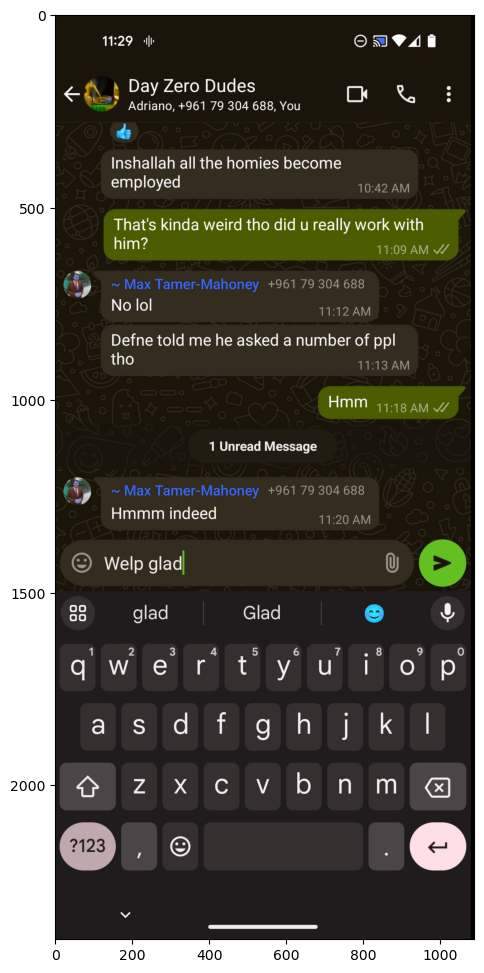

In [30]:
plt.figure(figsize=(8,12))
plt.imshow(im)

In [57]:
# outputs = {}
# for i, row in result_df.iterrows():
#     if os.path.exists(row['path']):
#         im = cv2.imread(row['path'])
#         output = generate(model, processor, im, prompt, verbose=False)
#         outputs[row['path']] = output

In [58]:
outputs

{'/Users/connorparish/code/hindsight/hindsight_server/data/raw_screenshots/2024/06/06/com-android-settings/com-android-settings_1717715350596.jpg': '2',
 '/Users/connorparish/code/hindsight/hindsight_server/data/raw_screenshots/2024/05/23/com-android-settings/com-android-settings_1716480961802.jpg': '10',
 '/Users/connorparish/code/hindsight/hindsight_server/data/raw_screenshots/2024/05/22/com-android-settings/com-android-settings_1716411190886.jpg': '4',
 '/Users/connorparish/code/hindsight/hindsight_server/data/raw_screenshots/2024/05/22/com-android-settings/com-android-settings_1716347261749.jpg': '7',
 '/Users/connorparish/code/hindsight/hindsight_server/data/raw_screenshots/2024/05/21/com-android-settings/com-android-settings_1716316172955.jpg': '25%'}

In [63]:
im = cv2.imread('/Users/connorparish/code/hindsight/hindsight_server/data/raw_screenshots/2024/05/23/com-android-settings/com-android-settings_1716480961802.jpg')

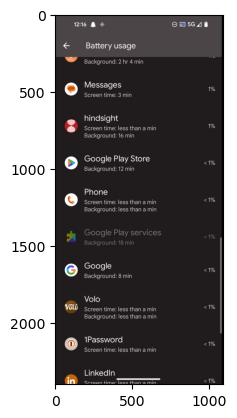

In [64]:
plt.imshow(im)

In [38]:
output = generate(model, processor, im, prompt, verbose=False)

In [39]:
output

'The screenshot shows that X uses 1% battery.'

# Extract info using CogVLM2

In [40]:
import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoTokenizer

In [41]:
import cv2 
image_path = '/Users/connorparish/code/hindsight/hindsight_server/data/raw_screenshots/2024/05/23/com-android-settings/com-android-settings_1716480961802.jpg'
im = Image.open(image_path).convert('RGB')

In [42]:
MODEL_PATH = "THUDM/cogvlm2-llama3-chat-19B"
# DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
DEVICE = 'cpu'
TORCH_TYPE = torch.float16

In [43]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_PATH,
    trust_remote_code=True
)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=TORCH_TYPE,
    trust_remote_code=True,
).to(DEVICE).eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/Users/connorparish/miniconda3/envs/hindsight_exp/lib/python3.9/site-packages/xformers/ops/swiglu_op.py:107: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(cls, ctx, x, w1, b1, w2, b2, w3, b3):
/Users/connorparish/miniconda3/envs/hindsight_exp/lib/python3.9/site-packages/xformers/ops/swiglu_op.py:128: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(cls, ctx, dx5):
Loading checkpoint shards: 100%|██████████| 8/8 [00:46<00:00,  5.85s/it]


In [44]:
history = []
query = f"This is a screenshot from a phone. What percentage of battery does hindsight use? The percentage is stored across from the app name."

input_by_model = model.build_conversation_input_ids(
    tokenizer,
    query=query,
    history=history,
    images=[im],
    template_version='chat'
)

In [45]:
inputs = {
    'input_ids': input_by_model['input_ids'].unsqueeze(0).to(DEVICE),
    'token_type_ids': input_by_model['token_type_ids'].unsqueeze(0).to(DEVICE),
    'attention_mask': input_by_model['attention_mask'].unsqueeze(0).to(DEVICE),
    'images': [[input_by_model['images'][0].to(DEVICE).to(TORCH_TYPE)]] if im is not None else None,
}
gen_kwargs = {
    "max_new_tokens": 2048,
    "pad_token_id": 128002,
}

: 

In [46]:
with torch.no_grad():
    outputs = model.generate(**inputs, **gen_kwargs)
    outputs = outputs[:, inputs['input_ids'].shape[1]:]
    response = tokenizer.decode(outputs[0])
    response = response.split("<|end_of_text|>")[0]
    print("\nCogVLM2:", response)

/Users/connorparish/miniconda3/envs/hindsight_exp/lib/python3.9/site-packages/transformers/utils/import_utils.py:653: FutureWarning: `torch._dynamo.external_utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  return dynamo.is_compiling()
